# 04 - Mobilitaet pro Bezirk

**Ziel:** Ermittelt OePNV- und Radwegeindikatoren pro Stadtbezirk auf OSM-Basis.

**Inputs:** data/interim/muc_bezirke_bev_clean.geojson, OSM-Haltestellen, OSM-Radwege

**Outputs:** data/processed/muc_bezirke_mobility.geojson

**Ausfuehrung:** Von oben nach unten ausfuehren (Restart & Run All). Dieses Notebook ist Teil der Pipeline 00 -> 05.


## Setup
In diesem Abschnitt werden Bibliotheken geladen und Pfade definiert. So ist der Ablauf reproduzierbar und alle nachfolgenden Schritte greifen auf eine konsistente Projektstruktur zu.


In [18]:
import geopandas as gpd
import osmnx as ox
from pathlib import Path
import matplotlib.pyplot as plt

BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data"
INTERIM_DIR = DATA_DIR / "interim"
PROCESSED_DIR = DATA_DIR / "processed"

BASE_DIR, INTERIM_DIR, PROCESSED_DIR


(PosixPath('..'), PosixPath('../data/interim'), PosixPath('../data/processed'))

## Datenbasis
Hier werden die drei zentralen Datengrundlagen vorbereitet: Bezirksgeometrien mit Bevölkerung, OSM-Haltestellen und OSM-Radwege. Ziel ist eine saubere Basis für die indikatorische Verknüpfung auf Bezirksebene.


### Bezirk DF laden
Die Bezirksdaten werden als geographisches Grundgerüst eingelesen und für Flächen-/Bevölkerungsbezüge genutzt. Diese Tabelle ist der Referenzrahmen für alle späteren Joins und Kennzahlen.


In [19]:
gdf_bez = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")
gdf_bez = gdf_bez[["bez_nr", "name", "einwohner", "geometry"]].copy()
gdf_bez.head()

,bez_nr,name,einwohner,geometry
0,1,Altstadt-Lehel,20876,"POLYGON ((692704.77 5336941.154, 692682.921 53..."
1,2,Ludwigsvorstadt-Isarvorstadt,50081,"POLYGON ((689722.841 5335359.37, 689570.385 53..."
2,3,Maxvorstadt,52434,"POLYGON ((690674.877 5336921.715, 690657.282 5..."
3,4,Schwabing-West,68610,"POLYGON ((691821.837 5339259.125, 691767.291 5..."
4,5,Au-Haidhausen,63972,"POLYGON ((693021.981 5335306.773, 693021.084 5..."


### Haltestellen aus OpenStreetMap laden
Die OSM-Punkte mit ÖPNV-Bezug werden für das Stadtgebiet geladen. Anschließend werden nur die für die Analyse relevanten Elemente weiterverarbeitet.


In [20]:
place_name = "München, Deutschland"

pt_tags = {
    "public_transport": ["platform", "stop_position"],
    "highway": "bus_stop",
    "railway": ["station", "halt", "tram_stop"]
}

gdf_pt_raw = ox.features_from_place(place_name, pt_tags)
gdf_pt_raw.head()


geometry  bus                   name network  \
element id                                                                      
node    245347  POINT (11.52027 48.14627)  yes    Wilhelm-Hale-Straße     NaN   
        295383  POINT (11.46862 48.17742)  yes      Willi-Wien-Straße     NaN   
        398761  POINT (11.58782 48.13766)  NaN            Maxmonument     MVV   
        428662   POINT (11.71534 48.1364)  yes  Sigmund-Riefler-Bogen     NaN   
        444575  POINT (11.50773 48.15276)  yes      Hirschgartenallee     NaN   

               operator public_transport share_taxi  \
element id                                            
node    245347      NaN    stop_position        NaN   
        295383      NaN    stop_position        NaN   
        398761      MVG    stop_position        NaN   
        428662      NaN    stop_position        NaN   
        444575      NaN    stop_position        NaN   

                                                  description railway tram  \
element id                                                                   
node    245347                                            NaN     NaN  NaN   
        295383                                            NaN     NaN  NaN   
        398761  Maxmonument, Stop Tram 19/N19 Richtung Pasing    stop  yes   
        428662                                            NaN     NaN  NaN   
        444575                                            NaN     NaN  NaN   

                ... towards destination check_date:lit seats backrest  \
element id      ...                                                     
node    245347  ...     NaN         NaN            NaN   NaN      NaN   
        295383  ...     NaN         NaN            NaN   NaN      NaN   
        398761  ...     NaN         NaN            NaN   NaN      NaN   
        428662  ...     NaN         NaN            NaN   NaN      NaN   
        444575  ...     NaN         NaN            NaN   NaN      NaN   

               disused:public_transport noexit type multipolygon source:height  
element id                                                                      
node    245347                      NaN    NaN  NaN          NaN           NaN  
        295383                      NaN    NaN  NaN          NaN           NaN  
        398761                      NaN    NaN  NaN          NaN           NaN  
        428662                      NaN    NaN  NaN          NaN           NaN  
        444575                      NaN    NaN  NaN          NaN           NaN  

[5 rows x 158 columns]

### Radwege aus OpenStreetMap laden
Die OSM-Linien für das Radwegenetz werden für München extrahiert. Darauf aufbauend wird die Radweglänge je Bezirk über geometrische Verschneidung bestimmt.


In [21]:
# Radwege aus OSM für München laden
cycle_tags = {
    "highway": ["cycleway", "path"],
    "cycleway": True  # erfasst Straßen mit cycleway=* Attribut
}

gdf_cycle_raw = ox.features_from_place(place_name, cycle_tags)
gdf_cycle = gdf_cycle_raw.to_crs(gdf_bez.crs).copy()

# Nur Linien-Geometrien behalten
gdf_cycle = gdf_cycle[gdf_cycle.geometry.type.isin(["LineString", "MultiLineString"])].copy()
gdf_cycle.head()

geometry crossing  \
element id                                                                    
way     2398598  LINESTRING (678321.324 5338985.322, 678330.8 5...      NaN   
        2398599  LINESTRING (678590.705 5338923.23, 678586.813 ...      NaN   
        3186527  LINESTRING (699607.328 5332097.029, 699605.243...      NaN   
        3221457  LINESTRING (689928.521 5338623.048, 689928.253...      NaN   
        3302608  LINESTRING (688726.171 5337858.573, 688726.301...      NaN   

                crossing:island crossing_ref    highway tactile_paving  \
element id                                                               
way     2398598             NaN          NaN  secondary            NaN   
        2398599             NaN          NaN  secondary            NaN   
        3186527             NaN          NaN       path            NaN   
        3221457             NaN          NaN       path            NaN   
        3302608             NaN          NaN       path            NaN   

                    bicycle crossing:markings kerb button_operated  ... image  \
element id                                                          ...         
way     2398598         NaN               NaN  NaN             NaN  ...   NaN   
        2398599         NaN               NaN  NaN             NaN  ...   NaN   
        3186527         yes               NaN  NaN             NaN  ...   NaN   
        3221457  designated               NaN  NaN             NaN  ...   NaN   
        3302608  designated               NaN  NaN             NaN  ...   NaN   

                parking:both:staggered type name:bar name:el name:he name:ru  \
element id                                                                     
way     2398598                    NaN  NaN      NaN     NaN     NaN     NaN   
        2398599                    NaN  NaN      NaN     NaN     NaN     NaN   
        3186527                    NaN  NaN      NaN     NaN     NaN     NaN   
        3221457                    NaN  NaN      NaN     NaN     NaN     NaN   
        3302608                    NaN  NaN      NaN     NaN     NaN     NaN   

                name:sr place tourism  
element id                             
way     2398598     NaN   NaN     NaN  
        2398599     NaN   NaN     NaN  
        3186527     NaN   NaN     NaN  
        3221457     NaN   NaN     NaN  
        3302608     NaN   NaN     NaN  

[5 rows x 318 columns]

## Datenaufbereitung
In diesem Abschnitt werden Rohdaten bereinigt, räumlich zugeordnet und zu belastbaren Bezirk-Kennzahlen aggregiert. Fokus sind vergleichbare Indikatoren für ÖPNV-Angebot und Radinfrastruktur.


### Vorbereitung der Haltestellen-Geometrie
Die ÖPNV-Features werden in ein einheitliches Punktformat überführt (CRS angleichen, Punktrepräsentation, Dublettenbereinigung). So wird verhindert, dass identische Haltestellen mehrfach gezählt werden.


In [22]:
# in CRS der Bezirke bringen
gdf_pt = gdf_pt_raw.to_crs(gdf_bez.crs).copy()

# Punktrepräsentation der Haltestellen erzeugen
gdf_pt["geometry"] = gdf_pt.geometry.centroid

# stabile ID je OSM-Feature und Geometrie-basierte Deduplizierung
# (mehrfach erfasste Haltestellen nicht doppelt zählen)
gdf_pt = gdf_pt.reset_index(drop=False).rename(columns={"index": "pt_uid"})
if "pt_uid" not in gdf_pt.columns:
    gdf_pt["pt_uid"] = gdf_pt.index.astype(str)

gdf_pt["x"] = gdf_pt.geometry.x.round(3)
gdf_pt["y"] = gdf_pt.geometry.y.round(3)
gdf_pt = gdf_pt.drop_duplicates(subset=["x", "y"]).copy()

# nur benötigte Spalten behalten
gdf_pt = gdf_pt[["pt_uid", "geometry"]].copy()
gdf_pt.head()


,pt_uid,geometry
0,0,POINT (687462.268 5335630.028)
1,1,POINT (683509.643 5338967.419)
2,2,POINT (692518.78 5334839.865)
3,3,POINT (702009.446 5335026.617)
4,4,POINT (686505.86 5336320.155)


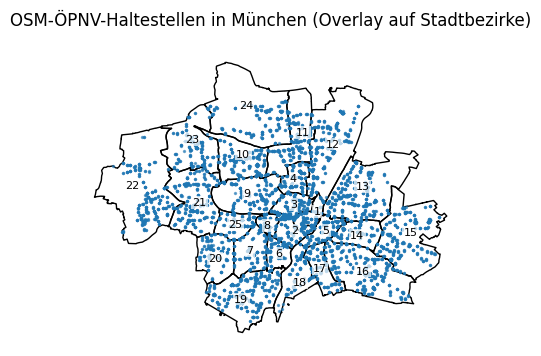

In [23]:
ax = gdf_bez.plot(edgecolor="black", facecolor="none", figsize=(5, 5))
gdf_pt.plot(ax=ax, markersize=2, alpha=0.6)
label_col = "sb_nummer" if "sb_nummer" in gdf_bez.columns else "bez_nr"
for _, row in gdf_bez.iterrows():
    rp = row.geometry.representative_point()
    ax.text(
        rp.x,
        rp.y,
        str(row[label_col]),
        fontsize=8,
        ha="center",
        va="center",
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none", "pad": 1},
    )
plt.title("OSM-ÖPNV-Haltestellen in München (Overlay auf Stadtbezirke)")
plt.axis("off")
plt.show()


#### Erkenntnisse (Overlay Haltestellen)
- Die Punktwolke bestätigt eine stadtweit flächige ÖPNV-Abdeckung, mit sichtbar höheren Dichten in zentralen und stark nachgefragten Lagen.
- Nach Bereinigung und Zuordnung werden insgesamt **6.404 Haltestellenpunkte** über **25 Bezirke** ausgewertet.
- Für den Bericht relevant: Die reine Anzahl ist nur bedingt vergleichbar; die normierte Kennzahl `stops_pro_1000_einw` ist belastbarer für Fairness zwischen Bezirken.


### Räumliche Zuordnung der Haltestellen zu Stadtbezirken
Die bereinigten Haltestellenpunkte werden per Spatial Join den Bezirken zugeordnet. Dadurch entsteht die Grundlage für absolute und bevölkerungsbezogene ÖPNV-Kennzahlen.


In [24]:
pt_in_bez = gpd.sjoin(
    gdf_pt,
    gdf_bez[["bez_nr", "geometry"]],
    how="inner",
    predicate="intersects"
)

# Falls ein Punkt mehrere Bezirke schneidet (Grenzfall), nur eine Zuordnung behalten
pt_in_bez = pt_in_bez.sort_values(["pt_uid", "bez_nr"]).drop_duplicates(subset=["pt_uid"]) 

pt_in_bez.head()


,pt_uid,geometry,index_right,bez_nr
0,0,POINT (687462.268 5335630.028),8,9
1,1,POINT (683509.643 5338967.419),22,23
10,10,POINT (697639.163 5333895.647),14,15
100,100,POINT (690302.986 5333810.893),1,2
1000,1000,POINT (692657.757 5338020.738),11,12


### Aggregation auf Bezirksebene und Ableitung von ÖPNV-Kennzahlen
Hier werden Haltestellen je Bezirk summiert und um den Indikator `stops_pro_1000_einw` ergänzt. Das ermöglicht faire Vergleiche zwischen unterschiedlich großen Bezirken.


In [25]:
# Anzahl Haltestellen je Bezirk
stops_per_bez = (
    pt_in_bez
    .groupby("bez_nr")
    .size()
    .reset_index(name="stops_count")
)

stops_per_bez.head(30)


,bez_nr,stops_count
0,1,177
1,2,332
2,3,191
3,4,176
4,5,251
5,6,117
6,7,142
7,8,92
8,9,272
9,10,295


### Räumliche Zuordnung Radwege zu Stadtbezirken
Radwege werden geometrisch mit Bezirksflächen verschnitten, damit nur die tatsächlich im Bezirk liegenden Streckenanteile gezählt werden. Das reduziert Verzerrungen an Bezirksgrenzen.


In [26]:
# Schnittmenge: Radwege ∩ Bezirke
cycle_in_bez = gpd.overlay(
    gdf_cycle[["geometry"]],
    gdf_bez[["bez_nr", "geometry"]],
    how="intersection"
)

# Länge je Radweg-Segment (in Meter)
cycle_in_bez["length_m"] = cycle_in_bez.geometry.length

cycle_in_bez.head()

,bez_nr,geometry,length_m
0,22,"LINESTRING (678321.324 5338985.322, 678330.8 5...",289.761912
1,22,"LINESTRING (678590.705 5338923.23, 678586.813 ...",321.180731
2,15,"LINESTRING (699607.328 5332097.029, 699605.243...",547.514533
3,11,"LINESTRING (689928.521 5338623.048, 689928.253...",89.115518
4,9,"LINESTRING (688726.171 5337858.573, 688726.301...",302.164243


### Aggregation auf Bezirksebene und Ableitung von Radweg-Kennzahlen
Die geschnittenen Linien werden je Bezirk zu Gesamtlängen aggregiert und über die Fläche zu Dichtewerten normalisiert (`radweg_km_pro_km2`). So wird Infrastrukturintensität unabhängig von Bezirksgröße vergleichbar.


In [27]:
# Gesamtlänge der Radwege pro Bezirk
cycle_per_bez = (
    cycle_in_bez
    .groupby("bez_nr")["length_m"]
    .sum()
    .reset_index()
    .rename(columns={"length_m": "radweg_length_m"})
)

cycle_per_bez.head()

,bez_nr,radweg_length_m
0,1,25011.805797
1,2,33868.056639
2,3,27996.472342
3,4,37562.549898
4,5,30467.493203


In [28]:
# Merge mit Bezirksbasis
gdf_mob = gdf_bez.merge(stops_per_bez, on="bez_nr", how="left")

# Bezirke ohne Haltestelle → 0
gdf_mob["stops_count"] = gdf_mob["stops_count"].fillna(0).astype(int)

# Kennzahl: Haltestellen pro 1.000 Einwohner
gdf_mob["stops_pro_1000_einw"] = (
    gdf_mob["stops_count"] / gdf_mob["einwohner"] * 1000
)

gdf_mob[["bez_nr", "name", "stops_count", "stops_pro_1000_einw"]].head()


,bez_nr,name,stops_count,stops_pro_1000_einw
0,1,Altstadt-Lehel,177,8.478636
1,2,Ludwigsvorstadt-Isarvorstadt,332,6.629261
2,3,Maxvorstadt,191,3.642675
3,4,Schwabing-West,176,2.565224
4,5,Au-Haidhausen,251,3.923592


In [29]:
# Radwege an gdf_mob joinen
gdf_mob = gdf_mob.merge(cycle_per_bez, on="bez_nr", how="left")

# NaN (keine Radwege) → 0
gdf_mob["radweg_length_m"] = gdf_mob["radweg_length_m"].fillna(0)

# in km umrechnen
gdf_mob["radweg_km"] = gdf_mob["radweg_length_m"] / 1000

# Radwegdichte: km Radweg pro km² Bezirksfläche
# flaeche_ha ist im Basis-DF, aber in 04 haben wir nur einwohner + geometry geladen.
# Lösung: flaeche_ha aus muc_bezirke_bev_clean nachziehen:
gdf_area = gpd.read_file(INTERIM_DIR / "muc_bezirke_bev_clean.geojson")[["bez_nr", "flaeche_ha"]]
gdf_mob = gdf_mob.merge(gdf_area, on="bez_nr", how="left")

gdf_mob["radweg_km_pro_km2"] = gdf_mob["radweg_km"] / (gdf_mob["flaeche_ha"] / 100)

gdf_mob[["bez_nr", "name", "radweg_km", "radweg_km_pro_km2"]].head()

,bez_nr,name,radweg_km,radweg_km_pro_km2
0,1,Altstadt-Lehel,25.011806,7.950604
1,2,Ludwigsvorstadt-Isarvorstadt,33.868057,7.694313
2,3,Maxvorstadt,27.996472,6.513534
3,4,Schwabing-West,37.562550,8.608748
4,5,Au-Haidhausen,30.467493,7.219785


## Explorative Analyse der Kennzahlen
Die Mobility-Kennzahlen werden tabellarisch sowie kartographisch und über Verteilungsplots ausgewertet. Ziel ist es, räumliche Muster und Ausreißer für den Bericht klar zu identifizieren.


In [30]:
gdf_mob[["bez_nr", "name", "stops_count", "stops_pro_1000_einw", "radweg_km", "radweg_km_pro_km2"]].head(30)

,bez_nr,name,stops_count,stops_pro_1000_einw,radweg_km,radweg_km_pro_km2
0,1,Altstadt-Lehel,177,8.478636,25.011806,7.950604
1,2,Ludwigsvorstadt-Isarvorstadt,332,6.629261,33.868057,7.694313
2,3,Maxvorstadt,191,3.642675,27.996472,6.513534
3,4,Schwabing-West,176,2.565224,37.562550,8.608748
4,5,Au-Haidhausen,251,3.923592,30.467493,7.219785
5,6,Sendling,117,2.853519,41.149906,10.447055
6,7,Sendling-Westpark,142,2.281491,80.602640,10.313970
7,8,Schwanthalerhöhe,92,3.207363,22.647510,10.939241
8,9,Neuhausen-Nymphenburg,272,2.669257,75.659151,5.858284
9,10,Moosach,295,5.266446,71.844213,6.476127


#### Erkenntnisse (Kennzahlentabelle)
- Die Spannweite ist deutlich: `stops_count` reicht von **92** (Schwanthalerhöhe) bis **502** (Bogenhausen), Median **239**.
- Bevölkerungsnormalisiert liegt `stops_pro_1000_einw` zwischen **2,28** und **8,48** (Median **3,64**), was auf klare Versorgungsunterschiede hinweist.
- Das Radwegenetz summiert sich auf rund **1.899,8 km**; je Bezirk reicht `radweg_km` von **22,65 km** bis **187,88 km**.
- Für die Berichtslogik: Absolute und normierte Kennzahlen sollten immer gemeinsam interpretiert werden, da große Bezirke sonst systematisch bevorzugt erscheinen.


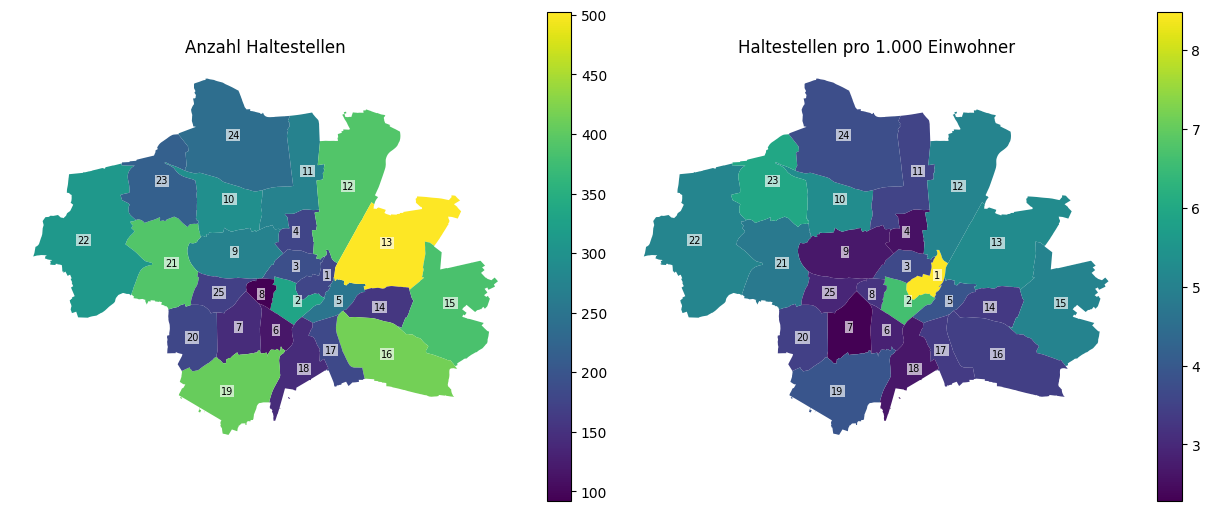

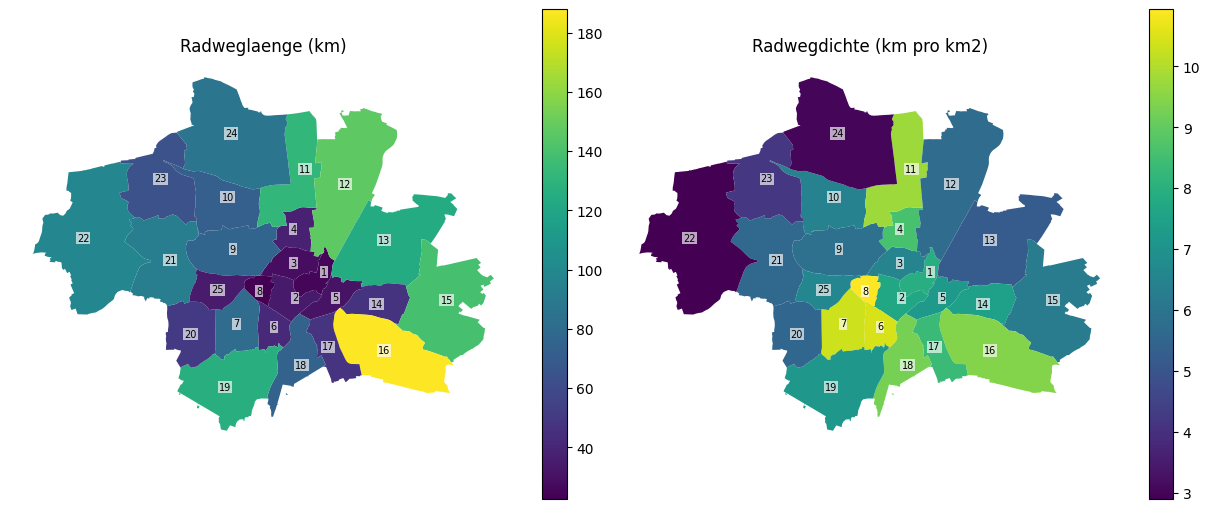

In [31]:
# Choroplethenkarten: OePNV-Indikatoren
pt_map_cols = [
    ("stops_count", "Anzahl Haltestellen"),
    ("stops_pro_1000_einw", "Haltestellen pro 1.000 Einwohner"),
]
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
label_col = "sb_nummer" if "sb_nummer" in gdf_mob.columns else "bez_nr"
for ax, (col, title) in zip(axes, pt_map_cols):
    gdf_mob.plot(column=col, legend=True, ax=ax)
    for _, row in gdf_mob.iterrows():
        rp = row.geometry.representative_point()
        ax.text(
            rp.x,
            rp.y,
            str(row[label_col]),
            fontsize=7,
            ha="center",
            va="center",
            color="black",
            bbox={"facecolor": "white", "alpha": 0.65, "edgecolor": "none", "pad": 0.8},
        )
    ax.set_title(title)
    ax.axis("off")
plt.show()
# Choroplethenkarten: Radwege-Indikatoren
bike_map_cols = [
    ("radweg_km", "Radweglaenge (km)"),
    ("radweg_km_pro_km2", "Radwegdichte (km pro km2)"),
]
fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
for ax, (col, title) in zip(axes, bike_map_cols):
    gdf_mob.plot(column=col, legend=True, ax=ax)
    for _, row in gdf_mob.iterrows():
        rp = row.geometry.representative_point()
        ax.text(
            rp.x,
            rp.y,
            str(row[label_col]),
            fontsize=7,
            ha="center",
            va="center",
            color="black",
            bbox={"facecolor": "white", "alpha": 0.65, "edgecolor": "none", "pad": 0.8},
        )
    ax.set_title(title)
    ax.axis("off")
plt.show()


#### Erkenntnisse (Choroplethenkarten)
- Die Karten sind thematisch getrennt: erst ÖPNV (absolut vs. je 1.000 Ew.), dann Radwege (absolut vs. je km²). Dadurch sind Muster pro Themenblock klarer vergleichbar.
- Im ÖPNV-Block wird der Unterschied zwischen absoluter Angebotsmenge und Bevölkerungsbezug sichtbar (z. B. Bogenhausen vs. Altstadt-Lehel).
- Im Radwege-Block wird der Kontrast zwischen Netzumfang und Flächendichte deutlich (z. B. Ramersdorf-Perlach vs. Schwanthalerhöhe).
- Die Bezirksnummern auf allen Karten erleichtern den direkten Abgleich mit Tabellen und Rankings im Bericht.


### Verteilung der Kennzahlen
Die folgenden Plots zeigen Histogramm und Boxplot für die beiden dichtebezogenen Kennzahlen. Damit lassen sich zentrale Lagen, Streuung und potenzielle Ausreißer schnell bewerten.


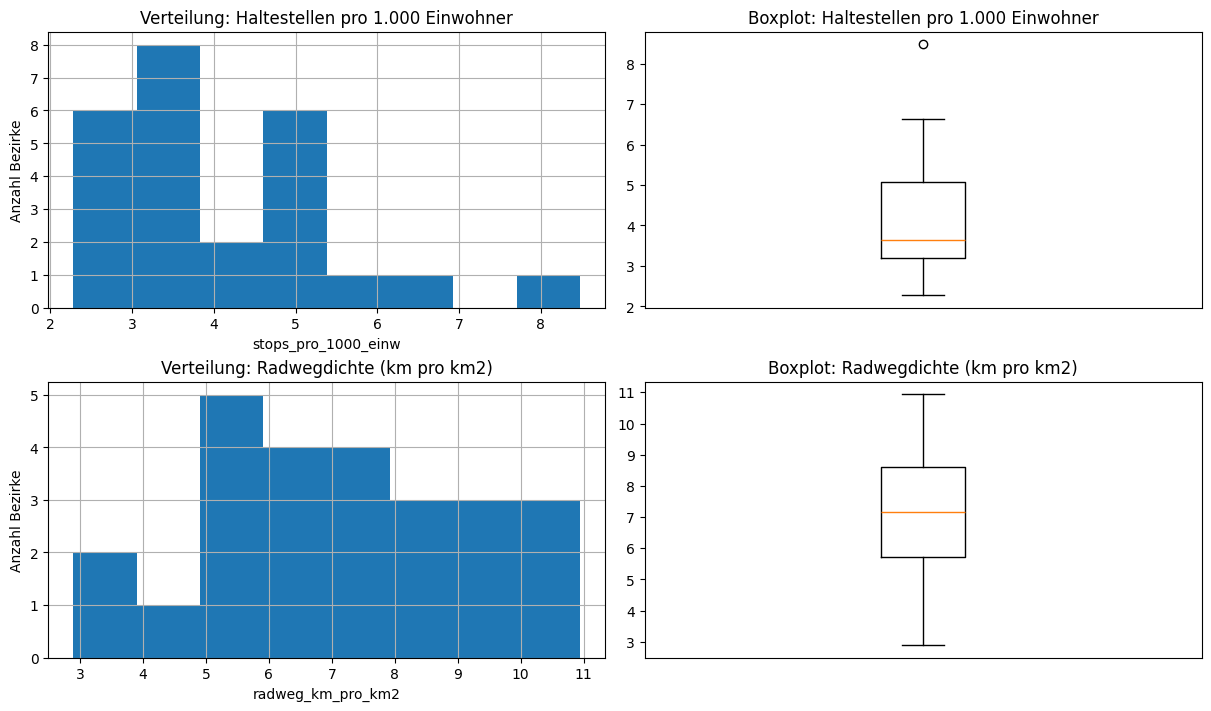

In [32]:
fig, axes = plt.subplots(2, 2, figsize=(12, 7), constrained_layout=True)

# Haltestellen pro 1.000 Einwohner
gdf_mob["stops_pro_1000_einw"].hist(ax=axes[0, 0], bins=8)
axes[0, 0].set_title("Verteilung: Haltestellen pro 1.000 Einwohner")
axes[0, 0].set_xlabel("stops_pro_1000_einw")
axes[0, 0].set_ylabel("Anzahl Bezirke")
axes[0, 1].boxplot(gdf_mob["stops_pro_1000_einw"], vert=True)
axes[0, 1].set_title("Boxplot: Haltestellen pro 1.000 Einwohner")
axes[0, 1].set_xticks([])

# Radwegdichte (km pro km2)
gdf_mob["radweg_km_pro_km2"].hist(ax=axes[1, 0], bins=8)
axes[1, 0].set_title("Verteilung: Radwegdichte (km pro km2)")
axes[1, 0].set_xlabel("radweg_km_pro_km2")
axes[1, 0].set_ylabel("Anzahl Bezirke")
axes[1, 1].boxplot(gdf_mob["radweg_km_pro_km2"], vert=True)
axes[1, 1].set_title("Boxplot: Radwegdichte (km pro km2)")
axes[1, 1].set_xticks([])

plt.show()


#### Erkenntnisse (Verteilungsplots)
- `stops_pro_1000_einw` ist rechtsschief verteilt: wenige Bezirke liegen deutlich über dem Median (**3,64**), die Mehrheit darunter oder im Nahbereich.
- Bei `radweg_km_pro_km2` liegt der Median bei **7,16 km/km²**; obere Ausprägungen um **10+ km/km²** markieren klar verdichtete Netze.
- Die Boxplots zeigen, dass beide Kennzahlen eine nennenswerte Streuung besitzen und damit für räumliche Differenzierung im Bericht geeignet sind.


### Ranking: Top- und Bottom-Bezirke
Top-5 und Bottom-5 werden für `stops_pro_1000_einw` und `radweg_km_pro_km2` dargestellt. Diese Gegenüberstellung macht Priorisierungsräume für Maßnahmen direkt sichtbar.


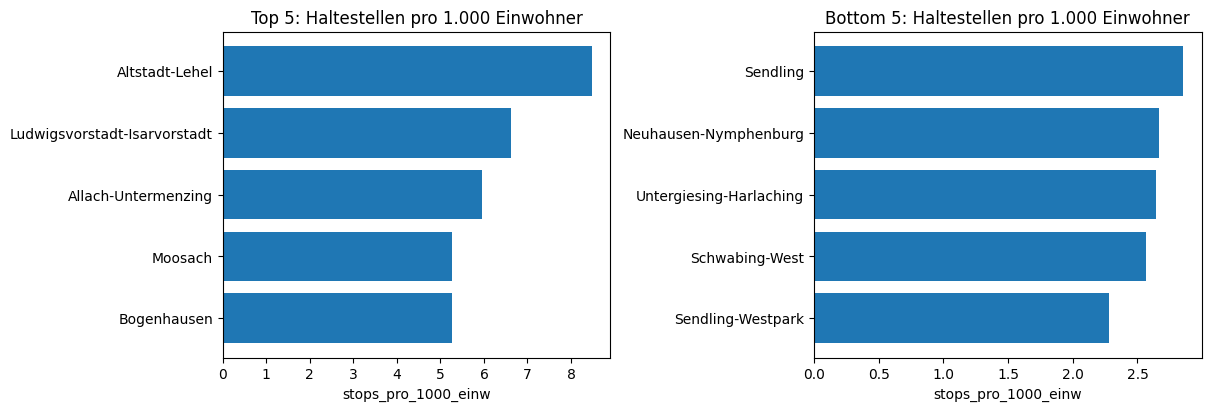

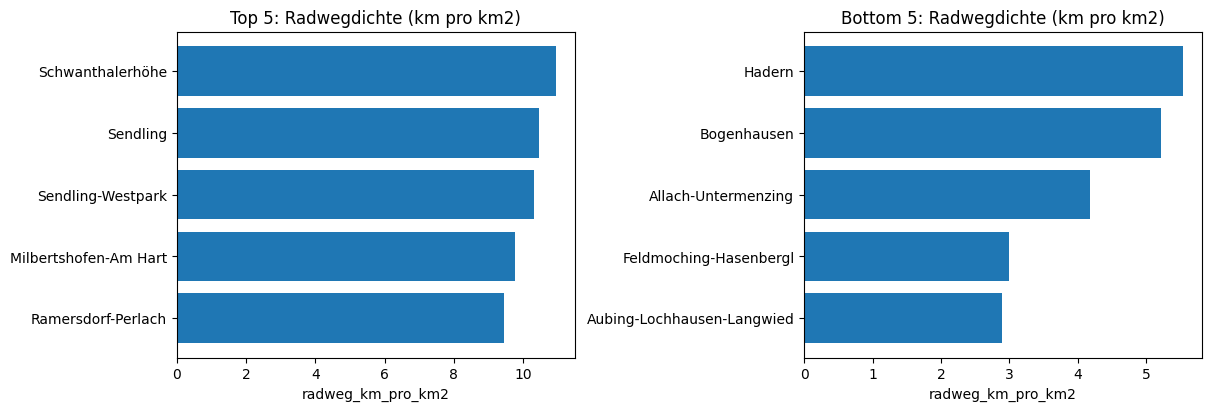

In [33]:
# Ranking 1: Haltestellen pro 1.000 Einwohner

top5_stops = (
    gdf_mob[["name", "stops_pro_1000_einw"]]
    .sort_values("stops_pro_1000_einw", ascending=False)
    .head(5)
    .sort_values("stops_pro_1000_einw", ascending=True)
)

bottom5_stops = (
    gdf_mob[["name", "stops_pro_1000_einw"]]
    .sort_values("stops_pro_1000_einw", ascending=True)
    .head(5)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].barh(top5_stops["name"], top5_stops["stops_pro_1000_einw"])
axes[0].set_title("Top 5: Haltestellen pro 1.000 Einwohner")
axes[0].set_xlabel("stops_pro_1000_einw")

axes[1].barh(bottom5_stops["name"], bottom5_stops["stops_pro_1000_einw"])
axes[1].set_title("Bottom 5: Haltestellen pro 1.000 Einwohner")
axes[1].set_xlabel("stops_pro_1000_einw")

plt.show()

# Ranking 2: Radwegdichte (km pro km2)

top5_rad = (
    gdf_mob[["name", "radweg_km_pro_km2"]]
    .sort_values("radweg_km_pro_km2", ascending=False)
    .head(5)
    .sort_values("radweg_km_pro_km2", ascending=True)
)

bottom5_rad = (
    gdf_mob[["name", "radweg_km_pro_km2"]]
    .sort_values("radweg_km_pro_km2", ascending=True)
    .head(5)
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)
axes[0].barh(top5_rad["name"], top5_rad["radweg_km_pro_km2"])
axes[0].set_title("Top 5: Radwegdichte (km pro km2)")
axes[0].set_xlabel("radweg_km_pro_km2")

axes[1].barh(bottom5_rad["name"], bottom5_rad["radweg_km_pro_km2"])
axes[1].set_title("Bottom 5: Radwegdichte (km pro km2)")
axes[1].set_xlabel("radweg_km_pro_km2")

plt.show()


#### Erkenntnisse (Top-/Bottom-Rankings)
- ÖPNV pro 1.000 Einwohner: Top-Werte in **Altstadt-Lehel (8,48)** und **Ludwigsvorstadt-Isarvorstadt (6,63)**, niedrige Werte u. a. in **Sendling-Westpark (2,28)**.
- Radwegdichte: hohe Werte in **Schwanthalerhöhe (10,94)** und **Sendling (10,45)**, niedrige Werte in **Aubing-Lochhausen-Langwied (2,90)**.
- Berichtsrelevant: Bezirke mit gleichzeitig schwachen Werten in mehreren Indikatoren sind plausible Kandidaten für priorisierte Infrastrukturmaßnahmen.


## Export
Der aufbereitete Mobility-Datensatz wird als `muc_bezirke_mobility.geojson` nach `data/processed/` exportiert. Die Datei dient als belastbare Input-Grundlage für Notebook 05.


In [34]:
out_path = PROCESSED_DIR / "muc_bezirke_mobility.geojson"
gdf_mob.to_file(out_path, driver="GeoJSON")
out_path


PosixPath('../data/processed/muc_bezirke_mobility.geojson')

#### Erkenntnisse (Export)
- Der Export bündelt alle abgeleiteten Mobilitätsindikatoren in einem konsistenten Geodatenformat.
- Damit sind die Kennzahlen direkt für die Indexbildung und Nachvollziehbarkeit in den Folgeschritten verwendbar.
